# Causal discovery applied to coupled logistic maps

In [1]:
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

# networks
import networkx as nx
from hierarchical_connectivities import hierarchical_connectivities # cantor algorithm
# flag: update c_nm in hierarchical_connectivities?

# couplings
from logistic_map_functions import logistic_map, logistic_map_N, logistic

# causality tests
from statsmodels.tsa.stattools import grangercausalitytests 
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

# evaluation
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

In [2]:

def adj_from_corr(corr, m, use_threshold=False):
    '''
    generates adjacency matrix from matrix of correlation / causation values
    
    
    '''
    corr = pd.DataFrame(corr)
    # take absolute value
    corr = np.abs(corr)
    # ignore diagonal and upper triangle entries in corr matrix
    for i in range(corr.shape[0]):
        corr.iloc[i,i] = -np.inf
        for j in range(i, corr.shape[0]):
            corr.iloc[i,j] = -np.inf
    
    if use_threshold==True:
        threshold = m
    elif use_threshold==False:
        # get cutoff value for the top M correlation coefficients
        threshold = corr.melt().sort_values(by='value', ascending=False).reset_index(drop=True).value[m]

    # get adjacency matrix
    corr_adj = np.array(corr>=threshold)
    
    return corr_adj


def adj_from_pval(caus, m, use_threshold=False):
    
    caus = pd.DataFrame(caus)
    # ignore diagonal entries (self-loops)
    for i in range(caus.shape[0]):
        caus.iloc[i,i] = np.inf
    
    if use_threshold==True:
        threshold = m
    elif use_threshold==False:
        # get cutoff value for the m smallest p-values
        threshold = caus.melt().sort_values(by='value', ascending=True).reset_index(drop=True).value[m]

    # get adjacency matrix
    caus_adj = np.array(caus<threshold)
    
    return caus_adj


def pairwise_granger(data, maxlag):
    '''
    performs pairwise granger causality tests for variables in dataset up to max. lag
    
    Parameters
    ----------
    data   :   dataframe of shape (time, variables)
    maxlag :   int,
               maximum lag.
            
    Returns
    -------
    grang : 3d array of shape (variables, variables, maxlag), 
            p-values of granger causality tests.

    '''
    # prepare output array (rows & cols are variables, 3rd dimension are lags)
    grang = np.zeros([data.shape[1], 
                     data.shape[1],
                     maxlag])

    for i in range(0,data.shape[1]):
        for j in range(0,data.shape[1]):
            tempg = grangercausalitytests(data.iloc[:,[i,j]], maxlag=maxlag, verbose=False)
            # store the p-value result for the ssr f-test:
            out = [tempg[x][0]['ssr_ftest'][1] for x in range(1,maxlag+1)]
            grang[i,j,0:maxlag] = np.array(out)
    
    return grang


def color_edge_matches(G1,G2):
    '''
    return colors for edges of G2
    (blue if edge is in G1, red otherwise)
    '''
    colors=[]
    for e in G2.edges:
        if e in G1.edges:
            colors.append('blue')
        else:
            colors.append('red')
            
    return colors


def eval_metrics(y_true, y_pred):
    '''
    compute f1, precision, recall
    
    Parameters
    ----------
    y_true  :  vector of true links, 
    y_pred  :  vector of predicted links,           

    Returns
    -------
    out : dataframe of evaluation metrics
    
    '''
    
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
    recall = recall_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
    
    out = pd.DataFrame({'f1':f1, 'precision':precision, 'recall':recall}, index=[0])
    
    return(out)

Let us initially simulate the traditional logistic map em 1D.

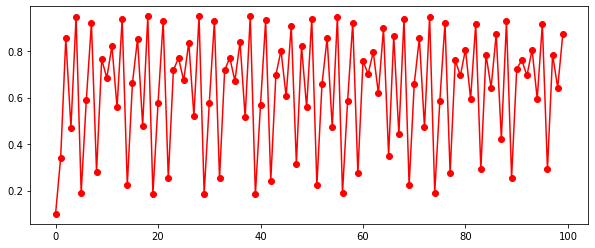

In [3]:
tmax = 100
x0 = 0.1
a = 3.8
x = logistic(x0,a,tmax)

plt.figure(figsize=(10,4))
plt.plot(np.arange(0,len(x)),x,'ro-')
plt.show(True)

Two-dimensional Poincaré plots:

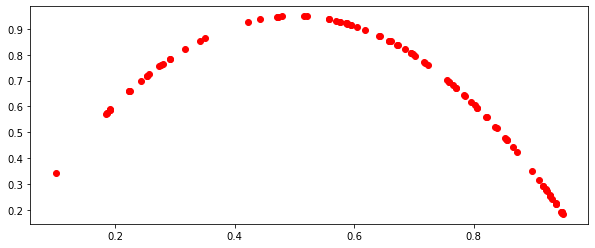

In [4]:
plt.figure(figsize=(10,4))

for t in range(0,tmax-1):
    plt.plot(x[t],x[t+1], 'ro')
plt.show(True)

### Networks

Let us adapt the logistic map to netowrks.

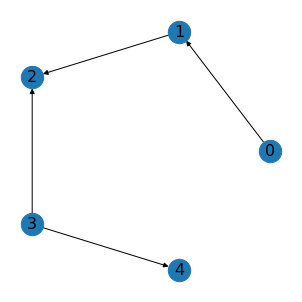

In [5]:
# Simple Networks
plt.figure(figsize=(4,4))

#N = 10
#av_degree = 1
#p = av_degree/(N-1)
#G = nx.gnp_random_graph(N, p, seed=None, directed=False)

#pos = nx.fruchterman_reingold_layout(G);
#plt.figure(figsize=(8,8));
#plt.axis("off");
#nx.draw_networkx_nodes(G, pos, node_size=300, node_color="black");
#nx.draw_networkx_edges(G, pos, alpha=0.500);
#nx.draw_networkx_labels(G, pos, font_color="white");
#plt.show();

edgelist=[(0,1),(1,2), (3,4),(3,2)]
G = nx.DiGraph(edgelist)
#G = nx.Graph(edgelist)

# get the adjacency matrix
G_adj = nx.to_numpy_matrix(G)
N = np.max(edgelist)

pos=nx.circular_layout(G)
nx.draw(G, with_labels = True, node_size=500, font_size=16, pos = pos)
plt.show(True)



We generate time series for this network:

In [6]:
# generate time series directly from networkx object
tmax = 100
N = len(G.nodes)
x = np.zeros((N,tmax))
M = len(G.edges)
sigma = 3
a = 3.8
x[:,0] = np.random.uniform(0,1,N)
for t in range(0,tmax-1):
    for i in G.nodes:
        x[i,t+1] = a*x[i,t]*(1-x[i,t])
        for j in G.predecessors(i): #for directed networks
        #for j in G.neighbors(i): # for undirected networks
            x[i,t+1] = x[i,t+1] + (sigma/M)*(a*x[j,t]*(1-x[j,t])-a*x[i,t]*(1-x[i,t]))

#print('Time series for each node:\n')
#for i in G.nodes:
    #print('Node:', i,'Neig:', list(G.predecessors(i)))
    #print('Node:', i, ':', x[i,:],'\n')

# save as dataframe
# rows are nodes, columns are time steps
data_networkx = pd.DataFrame(x.T)


Construct hierarchical network based on the cantor algorithm:

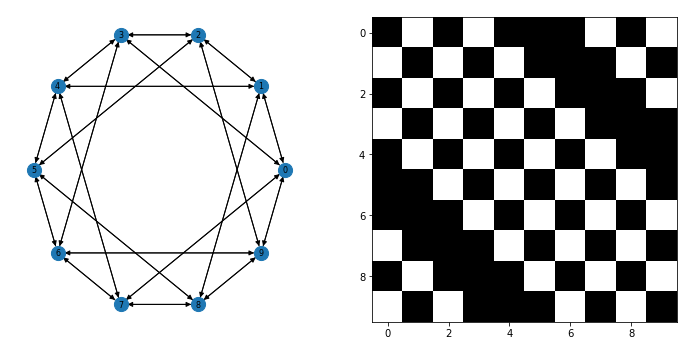

In [7]:
# Hierarchical network / Cantor algorithm

base = [1,0,1] # base pattern
m = 2
n = 1
# generate the adjacency matrix
C, c_nm = hierarchical_connectivities(base,n,m)

# networkx object
H = nx.from_numpy_matrix(C, create_using = nx.DiGraph())
pos_h=nx.circular_layout(H)

# plot network and adjacency matrix
plt.figure(figsize=(12,6))
plt.subplot(121); nx.draw(H, with_labels = True, node_size=200, font_size=8, pos = pos_h)
plt.subplot(122); plt.imshow(pd.DataFrame(C), cmap='gray')
plt.show(True)

Corresponding time series:

In [8]:
# initialize the nodes
z_0 = np.random.rand(C.shape[0])

parameters = {'a': 4,
             's': 0.1,
             'T':100}

# generate time series for hierarchical network
# nodes are columns, rows are time steps
Z = logistic_map_N(z=z_0, C_ij=C, parameters=parameters)

data_hierarchical = pd.DataFrame(data=Z)

In [9]:
data_hierarchical.shape

(100, 10)

### Correlation

In [10]:
corr_networkx = data_networkx.corr()
corr_hierarchical = data_hierarchical.corr()

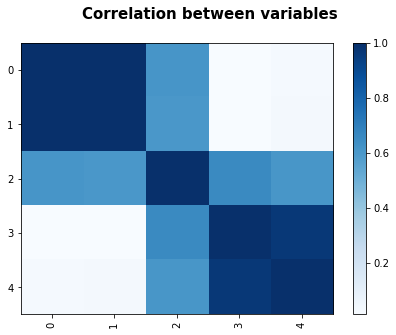

In [11]:
plt.figure(figsize=(7, 5))
plt.imshow(corr_networkx, cmap='Blues', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr_networkx)), corr_networkx.columns, rotation='vertical')
plt.yticks(range(len(corr_networkx)), corr_networkx.columns);
plt.suptitle('Correlation between variables', fontsize=15, fontweight='bold')
plt.grid(False)
plt.show()

In [12]:
# get adjacency matrix from correlations
corr_adj_networkx = adj_from_corr(corr_networkx, len(G.edges), use_threshold=False)


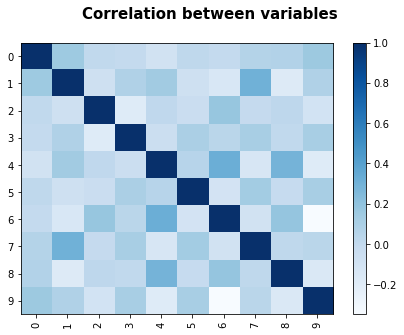

In [13]:
plt.figure(figsize=(7, 5))
plt.imshow(corr_hierarchical, cmap='Blues', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr_hierarchical)), corr_hierarchical.columns, rotation='vertical')
plt.yticks(range(len(corr_hierarchical)), corr_hierarchical.columns);
plt.suptitle('Correlation between variables', fontsize=15, fontweight='bold')
plt.grid(False)
plt.show()

In [14]:
# get adjacency matrix from correlations
corr_adj_hierarchical = adj_from_corr(corr_hierarchical, len(H.edges), use_threshold=False)


### Granger Causality

In [15]:
maxlag=3
grang_networkx = pairwise_granger(data_networkx, maxlag)
grang_hierarchical = pairwise_granger(data_hierarchical, maxlag)

In [16]:
# create ajacency matrix
# for each variable pair, take most significant p-value
grang_adj_nx = adj_from_pval(grang_networkx.min(axis=2), len(G.edges), use_threshold=False)
grang_adj_h = adj_from_pval(grang_hierarchical.min(axis=2), len(H.edges), use_threshold=False)


### PCMCI - ParCorr

In [17]:
data = data_networkx

tau_max = 3

# prep data
dataframe = pp.DataFrame(data.values, datatime = data.index, var_names=data.columns)
# parcorr - run pcmci
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(dataframe=dataframe, 
              cond_ind_test=parcorr,
              verbosity=0)

pcmci.verbosity = 0
results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=None)
# correct p-values
q_matrix_nx = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')



In [18]:
data = data_hierarchical

tau_max = 3

# prep data
dataframe = pp.DataFrame(data.values, datatime = data.index, var_names=data.columns)
# parcorr - run pcmci
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(dataframe=dataframe, 
              cond_ind_test=parcorr,
              verbosity=0)

pcmci.verbosity = 0
results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=None)
# correct p-values
q_matrix_h = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')



In [19]:
# create ajacency matrix
# for each variable pair, take most significant p-value
parcorr_adj_nx = adj_from_pval(q_matrix_nx.min(axis=2), len(G.edges), use_threshold=False)
parcorr_adj_h = adj_from_pval(results['p_matrix'][:,:,1:].min(axis=2), len(H.edges), use_threshold=False)



### Evaluation

Plot resulting networks and evaluate the performance of each detection method.

In [20]:
# set up nx objects

# from correlation adjacency matrix:
G2 = nx.from_numpy_matrix(corr_adj_networkx, create_using = nx.Graph())
H2 = nx.from_numpy_matrix(corr_adj_hierarchical, create_using = nx.Graph())
# from granger adjacency matrix:
G3 = nx.from_numpy_matrix(grang_adj_nx, create_using = nx.DiGraph())
H3 = nx.from_numpy_matrix(grang_adj_h, create_using = nx.DiGraph())
# from pcmci - parcorr adjacency matrix:
G4 = nx.from_numpy_matrix(parcorr_adj_nx, create_using = nx.DiGraph())
H4 = nx.from_numpy_matrix(parcorr_adj_h, create_using = nx.DiGraph())


In [21]:
# get the edge colors (blue=match, red=wrong)
colors_g2 = color_edge_matches(G,G2)
colors_g3 = color_edge_matches(G,G3)
colors_g4 = color_edge_matches(G,G4)

colors_h2 = color_edge_matches(H,H2)
colors_h3 = color_edge_matches(H,H3)
colors_h4 = color_edge_matches(H,H4)


Text(0.5, 0.98, 'NetworkX Graph')

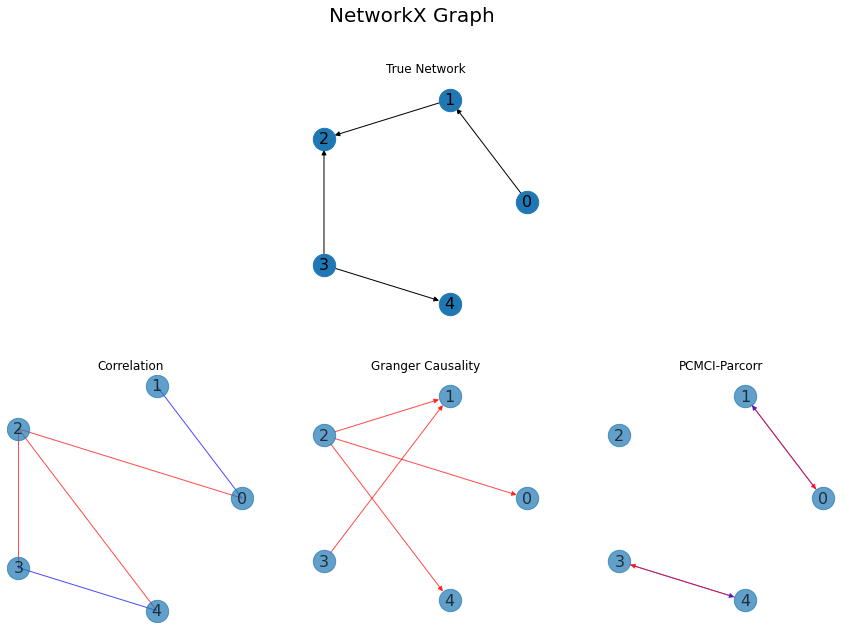

In [22]:
# plot all the graphs
plt.figure(figsize = (15,10))

# real (directed)
plt.subplot(232)
nx.draw(G, with_labels = True, node_size=500, font_size=16, pos = pos)
plt.title('True Network')

# correlation (undirected)
plt.subplot(234)
nx.draw(G2, with_labels = True, node_size=500, font_size=16, pos = pos, edge_color = colors_g2, alpha=0.7)
plt.title('Correlation')

# granger
plt.subplot(235)
nx.draw(G3, with_labels = True, node_size=500, font_size=16, pos = pos, edge_color = colors_g3, alpha=0.7)
plt.title('Granger Causality')

# pcmci - parcorr
plt.subplot(236)
nx.draw(G4, with_labels = True, node_size=500, font_size=16, pos = pos, edge_color = colors_g4, alpha=0.7)
plt.title('PCMCI-Parcorr')

plt.suptitle('NetworkX Graph', fontsize=20)

In [23]:
# to compute evaluation metrics for correlation, need to get adjacency metrics for undirected graphs
# get adjacency matrix for correlation (as undirected graph)
G2_adj = nx.to_numpy_matrix(G2)
# get undirected adjacency matrix for networkx graph
G_undir = G.to_undirected()
G_adj_undir = nx.to_numpy_matrix(G_undir)

In [24]:
metrics = pd.concat([eval_metrics(y_true=np.array(G_adj_undir.ravel())[0], y_pred=np.array(G2_adj.ravel())[0]),
                     eval_metrics(y_true=np.array(G_adj.ravel())[0], y_pred=parcorr_adj_nx.flatten().astype(float)),
                     eval_metrics(y_true=np.array(G_adj.ravel())[0], y_pred=grang_adj_nx.flatten().astype(float))
                     ], axis=0)
metrics.index = ['correlation', 'pcmci-parcorr','granger']

round(metrics,3)

,f1,precision,recall
correlation,0.667,0.6,0.75
pcmci-parcorr,0.500,0.5,0.50
granger,0.000,0.0,0.00


Note: For correlation, evaluation metrics are computed on the undirected network. For PCMCI and Granger causality, they are computed on the directed network.

Text(0.5, 0.98, 'Hierarchical Graph')

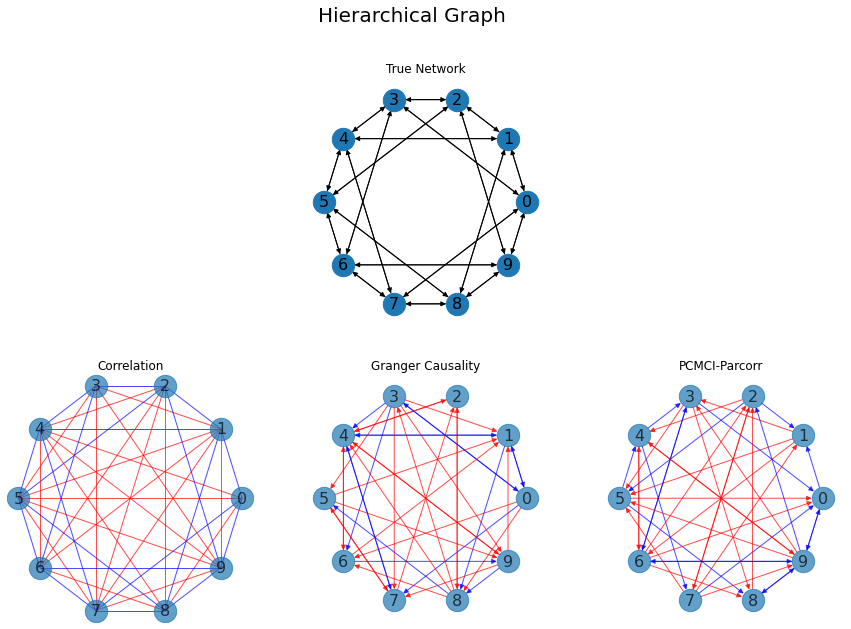

In [25]:
# plot all the graphs
plt.figure(figsize = (15,10))

# real (directed)
plt.subplot(232)
nx.draw(H, with_labels = True, node_size=500, font_size=16, pos = pos_h)
plt.title('True Network')

# correlation (undirected)
plt.subplot(234)
nx.draw(H2, with_labels = True, node_size=500, font_size=16, pos = pos_h, edge_color = colors_h2, alpha=0.7)
plt.title('Correlation')

# granger
plt.subplot(235)
nx.draw(H3, with_labels = True, node_size=500, font_size=16, pos = pos_h, edge_color = colors_h3, alpha=0.7)
plt.title('Granger Causality')

# pcmci - parcorr
plt.subplot(236)
nx.draw(H4, with_labels = True, node_size=500, font_size=16, pos = pos_h, edge_color = colors_h4, alpha=0.7)
plt.title('PCMCI-Parcorr')

plt.suptitle('Hierarchical Graph', fontsize=20)

In [26]:
# to compute evaluation metrics for correlation, need to get adjacency metrics for undirected graphs
# get adjacency matrix for correlation (as undirected graph)
H2_adj = nx.to_numpy_matrix(H2)
# get undirected adjacency matrix for networkx graph
H_undir = H.to_undirected()
H_adj_undir = nx.to_numpy_matrix(H_undir)

In [27]:
metrics = pd.concat([eval_metrics(y_true=np.array(H_adj_undir.ravel())[0], y_pred=np.array(H2_adj.ravel())[0]),
                     eval_metrics(y_true=np.array(C.ravel()), y_pred=parcorr_adj_h.flatten().astype(float)),
                     eval_metrics(y_true=np.array(C.ravel()), y_pred=grang_adj_h.flatten().astype(float))
                     ], axis=0)
metrics.index = ['correlation', 'pcmci-parcorr','granger']

round(metrics,3)

,f1,precision,recall
correlation,0.623,0.463,0.950
pcmci-parcorr,0.450,0.450,0.450
granger,0.375,0.375,0.375


## Varying Parameters

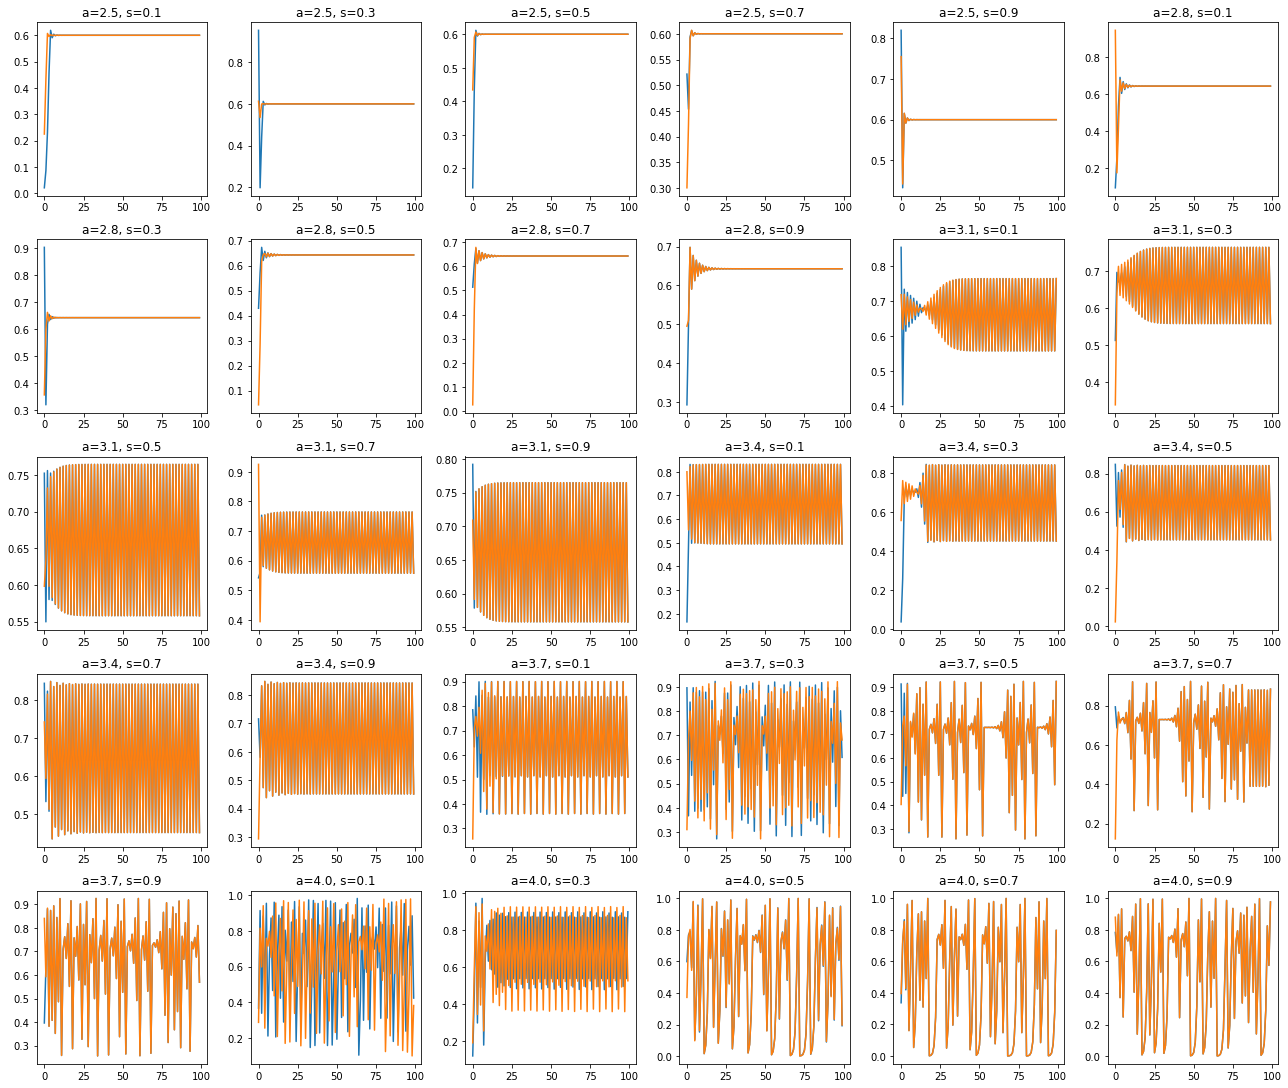

In [30]:
np.random.seed(10)
fig = plt.figure(figsize = (18,18))
count_subplot = 1
metrics_all = pd.DataFrame()
for a in np.arange(2.5, 4.1, 0.3):
    for s in np.arange(0.1,1.1,0.2):
        # initialize the nodes
        z_0 = np.random.rand(C.shape[0])

        parameters = {'a': a,
                     's': s,
                     'T':100}

        # generate time series for hierarchical network
        # nodes are columns, rows are time steps
        Z = logistic_map_N(z=z_0, C_ij=C, parameters=parameters)

        data_hierarchical = pd.DataFrame(data=Z)
        # plot 2 nodes
        fig.add_subplot(6,6,count_subplot)
        plt.plot(data_hierarchical[[1,5]])
        plt.title('a='+str(round(a,1))+', s='+str(round(s,1)))
        plt.tight_layout()
        count_subplot +=1
        
        #print('a='+str(round(a,1))+', s='+str(round(s,1)))

        # 1. correlation
        corr_hierarchical = data_hierarchical.corr()
        # get adjacency matrix from correlations
        corr_adj_hierarchical = adj_from_corr(corr_hierarchical, len(H.edges), use_threshold=False)


        # 2. granger causality
        maxlag=3
        grang_hierarchical = pairwise_granger(data_hierarchical, maxlag)
        # adj matrix
        grang_adj_h = adj_from_pval(grang_hierarchical.min(axis=2), len(H.edges), use_threshold=False)


        # 3. pcmci - parcorr
        data = data_hierarchical
        tau_max = 3
        # prep data
        dataframe = pp.DataFrame(data.values, datatime = data.index, var_names=data.columns)
        # parcorr - run pcmci
        parcorr = ParCorr(significance='analytic')
        pcmci = PCMCI(dataframe=dataframe, 
                      cond_ind_test=parcorr,
                      verbosity=0)

        pcmci.verbosity = 0
        results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=None)
        # correct p-values
        #q_matrix_h = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
        # adjacency matrix
        parcorr_adj_h = adj_from_pval(results['p_matrix'][:,:,1:].min(axis=2), len(H.edges), use_threshold=False)


        # evaluation
        # from correlation adjacency matrix:
        H2 = nx.from_numpy_matrix(corr_adj_hierarchical, create_using = nx.Graph())
        H2_adj = nx.to_numpy_matrix(H2)
        # get undirected adjacency matrix for networkx graph
        H_undir = H.to_undirected()
        H_adj_undir = nx.to_numpy_matrix(H_undir)
        # compute the metrics
        metrics = pd.concat([eval_metrics(y_true=np.array(H_adj_undir.ravel())[0], y_pred=np.array(H2_adj.ravel())[0]),
                             eval_metrics(y_true=np.array(C.ravel()), y_pred=parcorr_adj_h.flatten().astype(float)),
                             eval_metrics(y_true=np.array(C.ravel()), y_pred=grang_adj_h.flatten().astype(float))
                             ], axis=0)
        metrics.index = ['correlation', 'pcmci-parcorr','granger']
        metrics['a'] = a
        metrics['s'] = s
        # append
        metrics_all = metrics_all.append(metrics)
        

In [31]:
pd.set_option('display.max_rows', 500, 'display.max_columns', 500)


round(metrics_all.sort_values(by='f1', ascending=False),2)

,f1,precision,recall,a,s
granger,0.68,0.68,0.68,2.5,0.9
correlation,0.66,0.49,1.00,3.7,0.3
correlation,0.62,0.46,0.95,3.4,0.1
correlation,0.62,0.46,0.95,3.7,0.5
correlation,0.62,0.46,0.95,2.8,0.5
correlation,0.62,0.46,0.95,3.1,0.3
correlation,0.62,0.46,0.95,3.1,0.9
correlation,0.62,0.46,0.95,3.4,0.5
correlation,0.62,0.46,0.95,3.4,0.7
correlation,0.62,0.46,0.95,3.7,0.1
